In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
from google.colab.data_table import DataTable
DataTable.max_columns = 60

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/Shared drives/EE660_Proj/Submissions")
import warnings
warnings.filterwarnings("ignore")
import logging
import re
import warnings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import random
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix #pip install mlxtend
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from qns3vm import QN_S3VM  #Thanks to Professor Jenkins and Fabian Gieseke, Antti Airola, Tapio Pahikkala, Oliver Kramer for this piece of code. 
                            #Link https://github.com/tmadl/semisup-learn/blob/master/methods/qns3vm.py

In [ ]:
def calc_metrics(y_true, y_pred, model_name):
  accuracy = accuracy_score(y_true, y_pred)
  macro_f1_score = f1_score(y_true, y_pred, average='macro')
  print("Accuracy:", accuracy)
  print("Macro f1-score:", macro_f1_score)
  print("\n")
  plt.clf()
  fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred), figsize=(8,6), cmap=plt.cm.Reds, colorbar = True)
  plt.xticks(range(2), ['positive', 'negative'])
  plt.yticks(range(2), ['positive', 'negative'])
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix for ' + model_name, fontsize=20)
  plt.show()
  print("\n\n")

#30% Labelled Data - Semi Supervised Learning

Loading Training Data

In [ ]:
valid_rows = []
with open('data/crx-ssl30-10-1tra.dat') as f:
  spamreader = csv.reader(f, delimiter=' ')
  for row in spamreader:
    if not(re.search('^@', row[0])):
      row = [re.sub(",","", i) for i in row]
      for i in range(len(row)):
        if row[i] == '<null>':
          row[i] = None
      valid_rows.append(row)
df_train30 = pd.DataFrame(valid_rows, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'])

Loading Testing Data

In [ ]:
valid_rows = []
with open('data/crx-ssl30-10-1tst.dat') as f:
  spamreader = csv.reader(f, delimiter=',')
  for row in spamreader:
    if not(re.search('^@', row[0])):
      row = [re.sub(",","", i) for i in row]
      for i in range(len(row)):
        if row[i] == '<null>':
          row[i] = None
      valid_rows.append(row)
df_test30 = pd.DataFrame(valid_rows, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'])

In [ ]:
def label_encode(dataset,labels):
  lb=LabelEncoder()
  for i in labels:
    lb.fit(dataset[i])
    dataset[i]=lb.transform(dataset[i])

labels = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13', 'Class']
label_encode(df_train30, labels)
label_encode(df_test30, labels)
df_train30['Class'] = df_train30['Class'].replace(2,-1)

In [ ]:
X = df_train30.iloc[:,:-1]
y = df_train30.iloc[:,-1]
X_test = df_test30.iloc[:,:-1]
y_test = df_test30.iloc[:,-1]
X_labeled = df_train30[df_train30['Class'] != -1].iloc[:,:-1]
y_labeled = df_train30[df_train30['Class'] != -1].iloc[:,-1]

# Self-Training Classifier

Baseline Model - Logistic Regression

Accuracy: 0.8333333333333334
Macro f1-score: 0.8266061619297826




<Figure size 432x288 with 0 Axes>

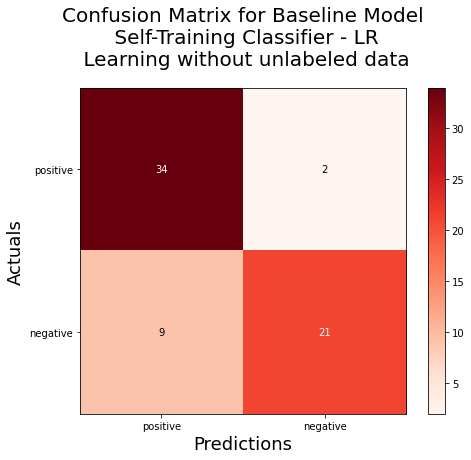

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model = LogisticRegression()
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X_labeled, y_labeled)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'Baseline Model\n Self-Training Classifier - LR\n Learning without unlabeled data')

Baseline model - SVC

Accuracy: 0.6666666666666666
Macro f1-score: 0.6329625884732053




<Figure size 432x288 with 0 Axes>

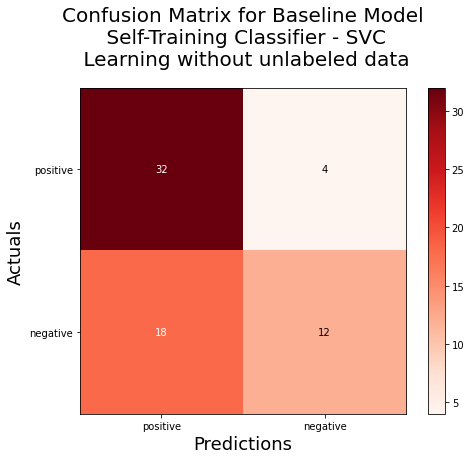

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model = SVC()
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X_labeled, y_labeled)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'Baseline Model\n Self-Training Classifier - SVC\n Learning without unlabeled data')

Logistic Regression with Self Training Classifier

Accuracy: 0.803030303030303
Macro f1-score: 0.789033685763462




<Figure size 432x288 with 0 Axes>

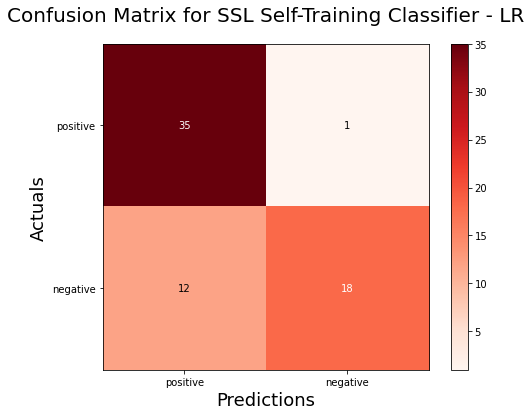

In [ ]:
model = LogisticRegression()
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X, y)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL Self-Training Classifier - LR')

SVC with Self Training Classifier

Accuracy: 0.5454545454545454
Macro f1-score: 0.3529411764705882




<Figure size 432x288 with 0 Axes>

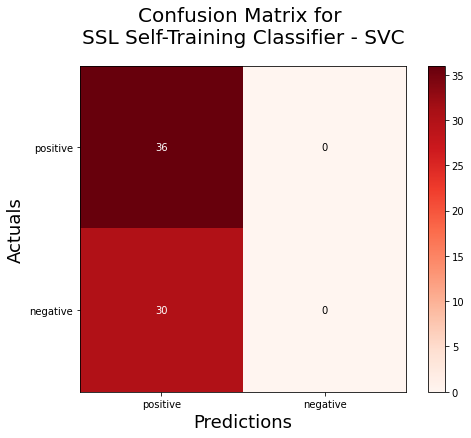

In [ ]:
svc = SVC(probability=True, gamma="auto")
self_training_model = SelfTrainingClassifier(svc)
self_training_model.fit(X, y)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'\nSSL Self-Training Classifier - SVC')

# Semi-Supervised GMM

Baseline Model for GMM

Accuracy: 0.5454545454545454
Macro f1-score: 0.3529411764705882




<Figure size 432x288 with 0 Axes>

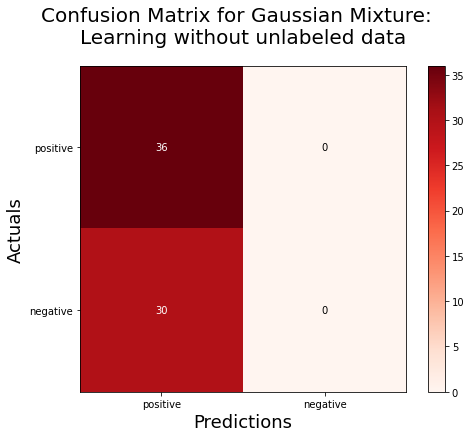

In [ ]:
X_train, X_unlab = df_train30[df_train30['Class'] != -1].iloc[:, :-1], df_train30[df_train30['Class'] == -1].iloc[:, :-1]
y_train, y_unlab = y[y.iloc[:] != -1], y[y.iloc[:] == -1]

clf = GaussianMixture(n_components=2, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
calc_metrics(y_test,y_pred,'Gaussian Mixture:  \nLearning without unlabeled data')

Mixture Models and Expectation Maximization Models - Approach 1


Accuracy: 0.5757575757575758
Macro f1-score: 0.4225




<Figure size 432x288 with 0 Axes>

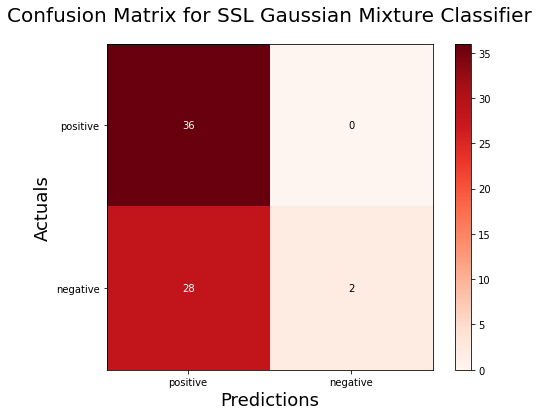

In [ ]:
#Thanks to Saptarsi Goswami for the reference
#Link https://www.kaggle.com/code/saptarsi/a-simple-semi-supervised-strategy-based-on-svm/notebook
# Estimate confidence for unlabeled data
probab = clf.predict_proba(X_unlab)
labels = clf.predict(X_unlab)

df = pd.DataFrame(probab, columns = ['Prob_Class_0', 'Prob_Class_1']) 
df['pred_label'] = labels
df['max_probab'] = df[['Prob_Class_0', 'Prob_Class_1']].max(axis=1)

# If confidence above certain threshold, append those values 
# to X_train and y_train, then retrain model
conf_levels = np.arange(.55, 1, .03)
scores = []
i = 0
max_score = float('-inf')
model = None
for k in conf_levels:
  conf_ind = df["max_probab"] > k
  X_train1 = np.append(np.array(X_train), np.array(X_unlab)[conf_ind,:], axis=0)
  y_train1 = np.append(y_train, df.loc[conf_ind, ['pred_label']])
  clf = GaussianMixture(n_components=2, random_state=0).fit(X_train1, y_train1)
  scores.append(clf.score(X_test, y_test))
  if scores[-1] >= max_score:
    max_score = scores[i]
    model = clf
  i = i + 1

y_pred = model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL Gaussian Mixture Classifier')

Mixture Models and Expectation Maximization Models - Approach 2

In [ ]:
# Thanks to RYOMIYAZAKI for the reference and the code
# Link https://www.kaggle.com/code/ryomiyazaki/semi-supervised-gaussian-mixture-model-with-em/notebook
# A few lines of the original code were modified to fit our use case
class SSGaussianMixture(object):
    def __init__(self, n_features, n_categories):
        self.n_features = n_features
        self.n_categories = n_categories
        
        self.mus = np.array([np.random.randn(n_features)]*n_categories)
        self.sigmas = np.array([np.eye(n_features)]*n_categories)
        self.pis = np.array([1/n_categories]*n_categories)
    def fit(self, X_train, y_train, X_test, threshold=0.00001, max_iter=100):
        Z_train = np.eye(self.n_categories)[y_train] 
        
        for i in range(max_iter):
        # EM algorithm
            # M step
            Z_test = np.array([self.gamma(X_test, k) for k in range(self.n_categories)]).T
            Z_test /= Z_test.sum(axis=1, keepdims=True)
        
            # E step
            datas = [X_train, Z_train, X_test, Z_test]
            mus = np.array([self._est_mu(k, *datas) for k in range(self.n_categories)])
            sigmas = np.array([self._est_sigma(k, *datas) for k in range(self.n_categories)])
            pis = np.array([self._est_pi(k, *datas) for k in range(self.n_categories)])
            diff = max(np.max(np.abs(mus-self.mus)), 
                       np.max(np.abs(sigmas-self.sigmas)), 
                       np.max(np.abs(pis-self.pis)))
            #print(diff)
            self.mus = mus
            self.sigmas = sigmas
            self.pis = pis
            if diff<threshold:
                break
                
                
    def predict_proba(self, X):
        Z_pred = np.array([self.gamma(X, k) for k in range(self.n_categories)]).T
        Z_pred /= Z_pred.sum(axis=1, keepdims=True)
        return Z_pred


    def gamma(self, X, k):
        # X is input vectors, k is feature index
        return stats.multivariate_normal.pdf(X, mean=self.mus[k], cov=self.sigmas[k])

    def _est_mu(self, k, X_train, Z_train, X_test, Z_test):
        mu = (Z_train[:,k]@X_train + Z_test[:,k]@X_test).T / \
                 (Z_train[:,k].sum() + Z_test[:,k].sum())
        return mu
    
    def _est_sigma(self, k, X_train, Z_train, X_test, Z_test):
        cmp1 = (X_train-self.mus[k]).T@np.diag(Z_train[:,k])@(X_train-self.mus[k])
        cmp2 = (X_test-self.mus[k]).T@np.diag(Z_test[:,k])@(X_test-self.mus[k])
        sigma = (cmp1+cmp2) / (Z_train[:,k].sum() + Z_test[:k].sum())
        return sigma
        
    def _est_pi(self, k, X_train, Z_train, X_test, Z_test):
        pi = (Z_train[:,k].sum() + Z_test[:,k].sum()) / \
                 (Z_train.sum() + Z_test.sum())
        return pi

class BaseClassifier(object):
    def __init__(self):
        self.preprocess = Pipeline([('vt', VarianceThreshold(threshold=2)), ('scaler', StandardScaler())])
        self.y_pred = None
        self.y_pred_test = None
 

    def fit(self, X_train, y_train, X_test, cv_qda=2, cv_meta=2):
        X_train_org = X_train
        self.preprocess_tune(np.vstack([X_train, X_test]))
        X_train = self.preprocess.transform(X_train)
        X_test = self.preprocess.transform(X_test)
        
        self.cgm = SSGaussianMixture(n_features=X_train.shape[1], n_categories=2)
        self.validation(X_train_org, y_train)
        self.cgm.fit(X_train, y_train, X_test)
        label_probab = self.cgm.predict_proba(X_test)
        y_label = []
        for i in label_probab:
          if i[0] > i[1]:
            y_label.append(0)
          else:
            y_label.append(1)
        self.y_pred_test = y_label

    def predict(self, X):
        X = self.preprocess.transform(X)
        return self.cgm.predict_proba(X)[:,1]
    
    
    def preprocess_tune(self, X):
        self.preprocess.fit(X)
                
        
    def validation(self, X, y):
        X = self.preprocess.transform(X)
        kf = KFold(n_splits=3, shuffle=False)
        scores = []
        y_pred_label = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.cgm.fit(X_train, y_train, X_test)
            y_pred = self.cgm.predict_proba(X_test)[:,1]
            scores.append(roc_auc_score(y_test, y_pred))
            gm = GaussianMixture(n_components=2, random_state=0).fit(X)
            label_probab = self.cgm.predict_proba(X_test)
            y_label = []
            for i in label_probab:
              if i[0] > i[1]:
                y_label.append(0)
              else:
                y_label.append(1)
            y_pred_label.extend(y_label)
        self.y_pred = y_pred_label
        self.score = np.array(scores).mean()
        print('validation score = ', self.score)

validation score =  0.8058235705865017
Accuracy: 0.7386363636363636
Macro f1-score: 0.7228536217992607




<Figure size 432x288 with 0 Axes>

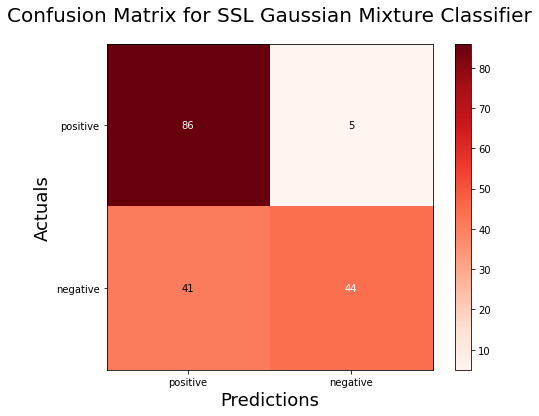

In [ ]:
bc = BaseClassifier()
bc.fit(X_train, y_train, X_unlab)
calc_metrics(y_train,bc.y_pred,'SSL Gaussian Mixture Classifier')

validation score =  0.9284973704517498
Accuracy: 0.6818181818181818
Macro f1-score: 0.6459770114942529




<Figure size 432x288 with 0 Axes>

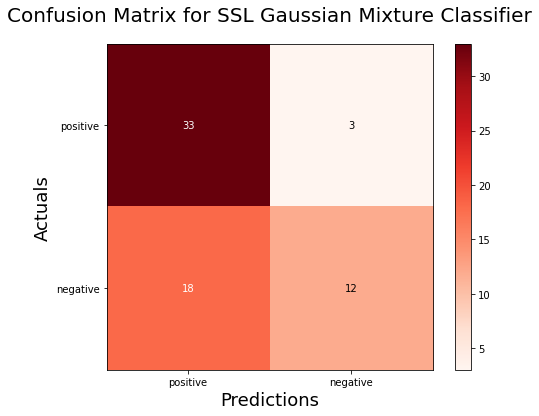

In [ ]:
y_train1 = pd.DataFrame(np.append(np.array(y_train), np.array(bc.y_pred_test), axis=0))
bc = BaseClassifier()
bc.fit(X, y_train1[0], X_test)
calc_metrics(y_test,bc.y_pred_test,'SSL Gaussian Mixture Classifier')

# Semi-Supervised SVM

Baseline model for SVM

Accuracy: 0.6666666666666666
Macro f1-score: 0.6329625884732053




<Figure size 432x288 with 0 Axes>

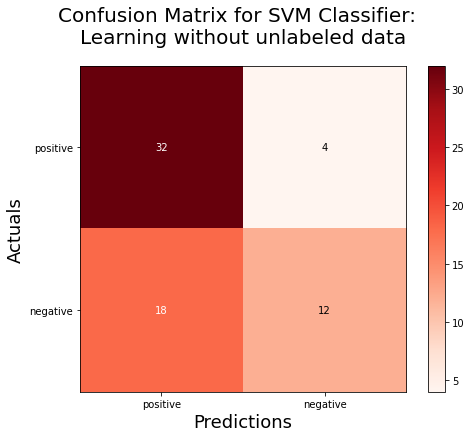

In [ ]:
X_train, X_unlab = df_train30[df_train30['Class'] != -1].iloc[:, :-1], df_train30[df_train30['Class'] == -1].iloc[:, :-1]
y_train, y_unlab = y[y.iloc[:] != -1], y[y.iloc[:] == -1]

# Use only labeled data to train a classifier
clf = SVC(kernel='rbf', probability=True,C=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
calc_metrics(y_test,y_pred,'SVM Classifier:  \nLearning without unlabeled data')

Semi-Supervised SVM - Approach 1

Accuracy: 0.6666666666666666
Macro f1-score: 0.6329625884732053




<Figure size 432x288 with 0 Axes>

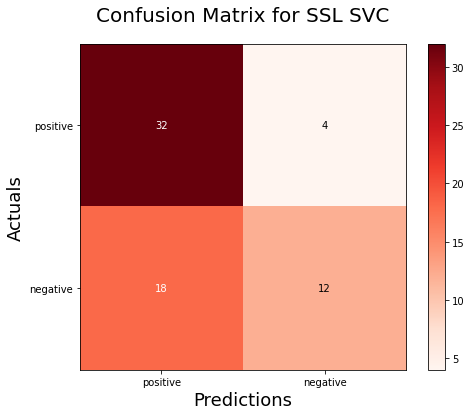

In [ ]:
#Thanks to Saptarsi Goswami for the reference
#Link https://www.kaggle.com/code/saptarsi/a-simple-semi-supervised-strategy-based-on-svm/notebook
# Estimate confidence for unlabeled data
probab = clf.predict_proba(X_unlab)
labels = clf.predict(X_unlab)

df = pd.DataFrame(probab, columns = ['Prob_Class_0', 'Prob_Class_1']) 
df['pred_label'] = labels
df['max_probab'] = df[['Prob_Class_0', 'Prob_Class_1']].max(axis=1)

# If confidence above certain threshold, append those values 
# to X_train and y_train, then retrain model
conf_levels = np.arange(.55, 1, .03)
scores = []
i = 0
max_score = 0
model = None
for k in conf_levels:
  conf_ind = df["max_probab"] > k
  X_train1 = np.append(np.array(X_train), np.array(X_unlab)[conf_ind,:], axis=0)
  y_train1 = np.append(y_train, df.loc[conf_ind, ['pred_label']])
  clf = SVC(kernel='rbf', probability=True, C=1).fit(X_train1, y_train1)
  scores.append(clf.score(np.array(X_test), np.array(y_test)))
  if scores[-1] >= max_score:
    max_score = scores[i]
    model = clf
  i = i + 1

y_pred = model.predict(np.array(X_test))
calc_metrics(y_test,y_pred,'SSL SVC')

Semi-Supervised SVM - Approach 2

Accuracy: 0.6666666666666666
Macro f1-score: 0.6398809523809523




<Figure size 432x288 with 0 Axes>

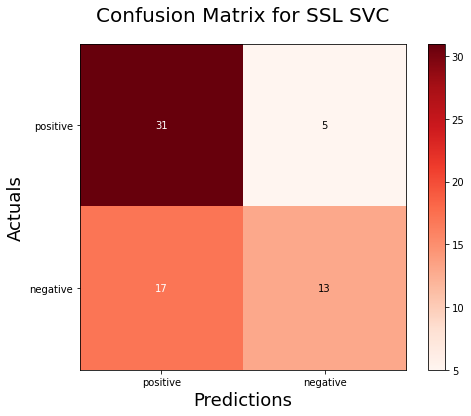

In [ ]:
X_train = X_train.astype(float)
X_unlab = X_unlab.astype(float)
X_test = X_test.astype(float)

y_train.replace(0,-1, inplace=True), y_test.replace(0,-1, inplace=True)
#Thanks to Professor Jenkins and Fabian Gieseke, Antti Airola, Tapio Pahikkala, Oliver Kramer for this piece of QN_S3VM. 
#Link https://github.com/tmadl/semisup-learn/blob/master/methods/qns3vm.py
X_list, y_list = list(X_train.values), list(y_train.values)
X_unlab = list(X_unlab.values)
s3vm = QN_S3VM(X_list, y_list, X_unlab, random.Random()) 
s3vm.train()
y_pred = s3vm.getPredictions(X_test)
calc_metrics(y_test,y_pred,'SSL SVC')

#20% Labelled Data

Loading training data

In [ ]:
valid_rows = []
with open('data/crx-ssl20-10-1tra.dat') as f:
  spamreader = csv.reader(f, delimiter=' ')
  for row in spamreader:
    if not(re.search('^@', row[0])):
      row = [re.sub(",","", i) for i in row]
      for i in range(len(row)):
        if row[i] == '<null>':
          row[i] = None
      valid_rows.append(row)
df_train20 = pd.DataFrame(valid_rows, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'])

Loading testing data

In [ ]:
valid_rows = []
with open('data/crx-ssl20-10-1tst.dat') as f:
  spamreader = csv.reader(f, delimiter=',')
  for row in spamreader:
    if not(re.search('^@', row[0])):
      row = [re.sub(",","", i) for i in row]
      for i in range(len(row)):
        if row[i] == '<null>':
          row[i] = None
      valid_rows.append(row)
df_test20 = pd.DataFrame(valid_rows, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'])

In [ ]:
labels = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13', 'Class']
label_encode(df_train20, labels)
label_encode(df_test20, labels)
df_train20['Class'] = df_train20['Class'].replace(2,-1)

X = df_train20.iloc[:,:-1]
y = df_train20.iloc[:,-1]
X_test = df_test20.iloc[:,:-1]
y_test = df_test20.iloc[:,-1]
X_labeled = df_train20[df_train20['Class'] != -1].iloc[:,:-1]
y_labeled = df_train20[df_train20['Class'] != -1].iloc[:,-1]

# Self Training Classifier

Baseline Model - Logistic Regression

Accuracy: 0.7878787878787878
Macro f1-score: 0.7806267806267806




<Figure size 432x288 with 0 Axes>

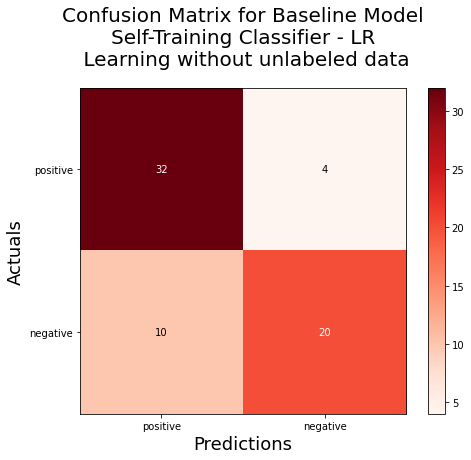

In [ ]:
model = LogisticRegression()
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X_labeled, y_labeled)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'Baseline Model\nSelf-Training Classifier - LR\n Learning without unlabeled data')

Baseline Model - SVC

Accuracy: 0.6515151515151515
Macro f1-score: 0.6122605363984674




<Figure size 432x288 with 0 Axes>

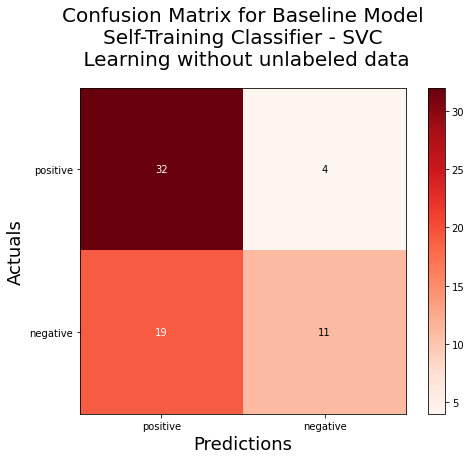

In [ ]:
model = SVC()
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X_labeled, y_labeled)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'Baseline Model\nSelf-Training Classifier - SVC\n Learning without unlabeled data')

Logistic Regression with Self Training Classifier

Accuracy: 0.7575757575757576
Macro f1-score: 0.7424390243902439




<Figure size 432x288 with 0 Axes>

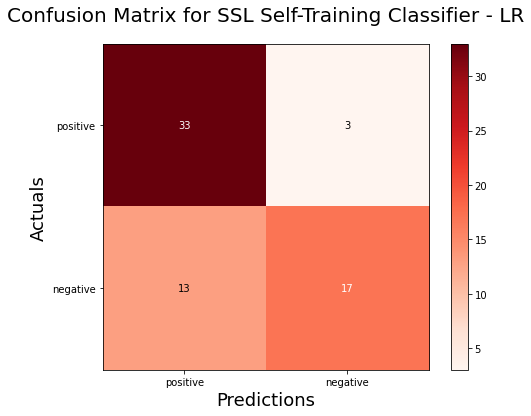

In [ ]:
model = LogisticRegression()
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X, y)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL Self-Training Classifier - LR')

SVC with Self Training Classifier

Accuracy: 0.4696969696969697
Macro f1-score: 0.34281650071123754




<Figure size 432x288 with 0 Axes>

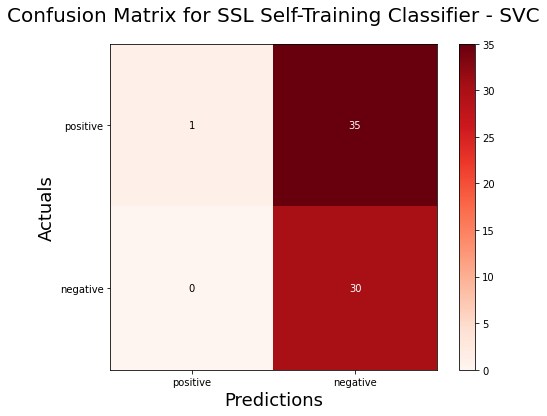

In [ ]:
svc = SVC(probability=True, gamma="auto")
self_training_model = SelfTrainingClassifier(svc)
self_training_model.fit(X, y)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL Self-Training Classifier - SVC')

# Semi-Supervised GMM

Baseline Model for GMM

Accuracy: 0.5454545454545454
Macro f1-score: 0.3529411764705882




<Figure size 432x288 with 0 Axes>

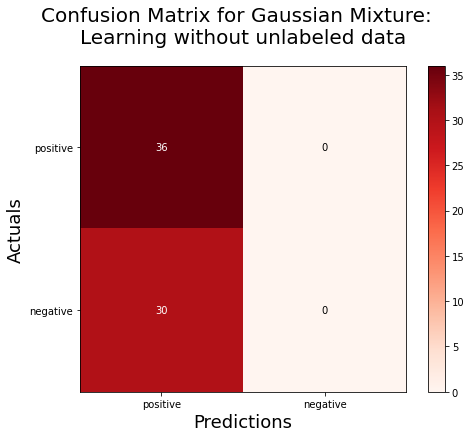

In [ ]:
X_train, X_unlab = df_train20[df_train20['Class'] != -1].iloc[:, :-1], df_train20[df_train20['Class'] == -1].iloc[:, :-1]
y_train, y_unlab = y[y.iloc[:] != -1], y[y.iloc[:] == -1]

clf = GaussianMixture(n_components=2, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
calc_metrics(y_test,y_pred,'Gaussian Mixture:  \nLearning without unlabeled data')

Mixture Models and Expectation Maximization Models - Approach 1

Accuracy: 0.5757575757575758
Macro f1-score: 0.4225




<Figure size 432x288 with 0 Axes>

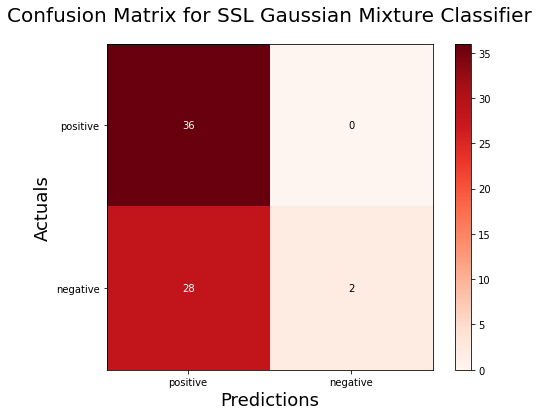

In [ ]:
#Thanks to Saptarsi Goswami for the reference
#Link https://www.kaggle.com/code/saptarsi/a-simple-semi-supervised-strategy-based-on-svm/notebook
# Estimate confidence for unlabeled data
probab = clf.predict_proba(X_unlab)
labels = clf.predict(X_unlab)

df = pd.DataFrame(probab, columns = ['Prob_Class_0', 'Prob_Class_1']) 
df['pred_label'] = labels
df['max_probab'] = df[['Prob_Class_0', 'Prob_Class_1']].max(axis=1)

# If confidence above certain threshold, append those values 
# to X_train and y_train, then retrain model
conf_levels = np.arange(.55, 1, .03)
scores = []
i = 0
max_score = float('-inf')
model = None
for k in conf_levels:
  conf_ind = df["max_probab"] > k
  X_train1 = np.append(np.array(X_train), np.array(X_unlab)[conf_ind,:], axis=0)
  y_train1 = np.append(y_train, df.loc[conf_ind, ['pred_label']])
  clf = GaussianMixture(n_components=2, random_state=0).fit(X_train1, y_train1)
  scores.append(clf.score(X_test, y_test))
  if scores[-1] >= max_score:
    max_score = scores[i]
    model = clf
  i = i + 1

y_pred = model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL Gaussian Mixture Classifier')

Mixture Models and Expectation Maximization Models - Approach 2

validation score =  0.8063027940220922
Accuracy: 0.6837606837606838
Macro f1-score: 0.6673326673326673




<Figure size 432x288 with 0 Axes>

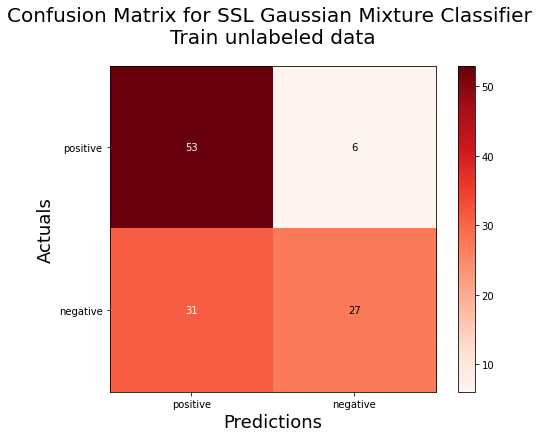




validation score =  0.925362091464251
Accuracy: 0.6818181818181818
Macro f1-score: 0.6378364253984843




<Figure size 432x288 with 0 Axes>

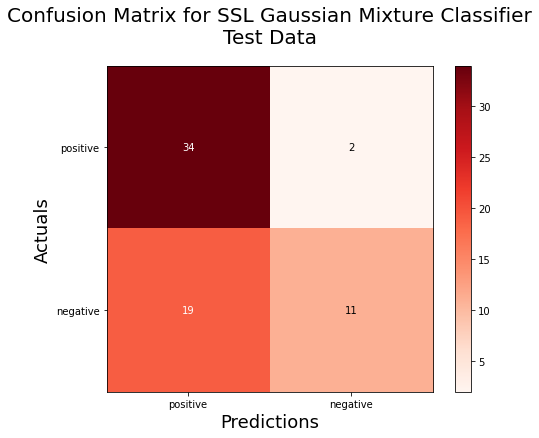

In [ ]:
bc = BaseClassifier()
bc.fit(X_train, y_train, X_unlab)
calc_metrics(y_train,bc.y_pred,'SSL Gaussian Mixture Classifier \nTrain unlabeled data')

y_train1 = pd.DataFrame(np.append(np.array(y_train), np.array(bc.y_pred_test), axis=0))
bc = BaseClassifier()
bc.fit(X, y_train1[0], X_test)
calc_metrics(y_test,bc.y_pred_test,'SSL Gaussian Mixture Classifier\nTest Data')

# Semi-Supervised SVM

Baseline Model

Accuracy: 0.6515151515151515
Macro f1-score: 0.6122605363984674




<Figure size 432x288 with 0 Axes>

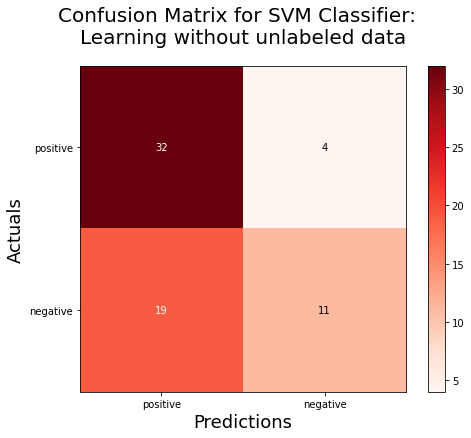

In [ ]:
X_train, X_unlab = df_train20[df_train20['Class'] != -1].iloc[:, :-1], df_train20[df_train20['Class'] == -1].iloc[:, :-1]
y_train, y_unlab = y[y.iloc[:] != -1], y[y.iloc[:] == -1]

# Use only labeled data to train a classifier
clf = SVC(kernel='rbf', probability=True,C=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
calc_metrics(y_test,y_pred,'SVM Classifier:  \nLearning without unlabeled data')

Semi-Supervised SVM - Approach 1

Accuracy: 0.6666666666666666
Macro f1-score: 0.6329625884732053




<Figure size 432x288 with 0 Axes>

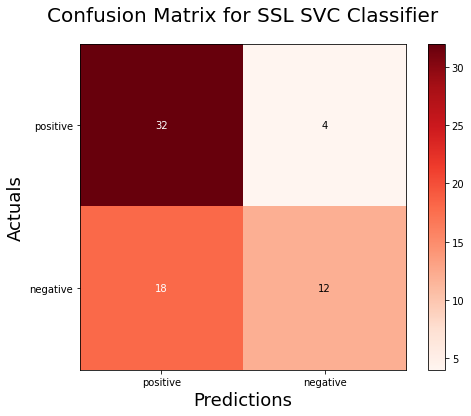

In [ ]:
#Thanks to Saptarsi Goswami for the reference
#Link https://www.kaggle.com/code/saptarsi/a-simple-semi-supervised-strategy-based-on-svm/notebook
# Estimate confidence for unlabeled data
probab = clf.predict_proba(X_unlab)
labels = clf.predict(X_unlab)

df = pd.DataFrame(probab, columns = ['Prob_Class_0', 'Prob_Class_1']) 
df['pred_label'] = labels
df['max_probab'] = df[['Prob_Class_0', 'Prob_Class_1']].max(axis=1)

# If confidence above certain threshold, append those values 
# to X_train and y_train, then retrain model
conf_levels = np.arange(.55, 1, .03)
scores = []
i = 0
max_score = 0
model = None
for k in conf_levels:
  conf_ind = df["max_probab"] > k
  X_train1 = np.append(np.array(X_train), np.array(X_unlab)[conf_ind,:], axis=0)
  y_train1 = np.append(y_train, df.loc[conf_ind, ['pred_label']])
  clf = SVC(kernel='rbf', probability=True, C=1).fit(X_train1, y_train1)
  scores.append(clf.score(X_test, y_test))
  if scores[-1] >= max_score:
    max_score = scores[i]
    model = clf
  i = i + 1

y_pred = model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL SVC Classifier')

Semi-Supervised SVM - Approach 2

Accuracy: 0.6515151515151515
Macro f1-score: 0.6200250312891114




<Figure size 432x288 with 0 Axes>

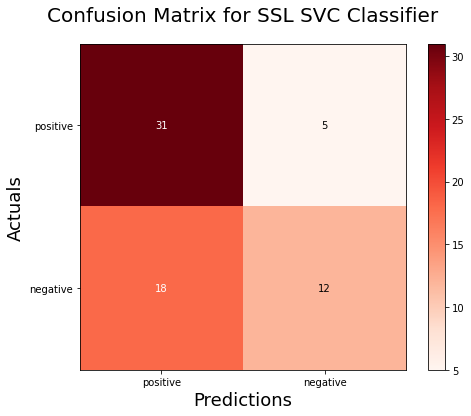

In [ ]:
X_train = X_train.astype(float)
X_unlab = X_unlab.astype(float)
X_test = X_test.astype(float)

y_train.replace(0,-1, inplace=True), y_test.replace(0,-1, inplace=True)
#Thanks to Professor Jenkins and Fabian Gieseke, Antti Airola, Tapio Pahikkala, Oliver Kramer for this piece of QN_S3VM. 
#Link https://github.com/tmadl/semisup-learn/blob/master/methods/qns3vm.py
X_list, y_list = list(X_train.values), list(y_train.values)
X_unlab = list(X_unlab.values)
s3vm = QN_S3VM(X_list, y_list, X_unlab, random.Random())
s3vm.train()
y_pred = s3vm.getPredictions(X_test)
calc_metrics(y_test,y_pred,'SSL SVC Classifier')

#10% Labelled Data

Loading training data

In [ ]:
valid_rows = []
with open('data/crx-ssl10-10-1tra.dat') as f:
  spamreader = csv.reader(f, delimiter=' ')
  for row in spamreader:
    if not(re.search('^@', row[0])):
      row = [re.sub(",","", i) for i in row]
      for i in range(len(row)):
        if row[i] == '<null>':
          row[i] = None
      valid_rows.append(row)
df_train10 = pd.DataFrame(valid_rows, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'])

Loading testing data

In [ ]:
valid_rows = []
with open('data/crx-ssl10-10-1tst.dat') as f:
  spamreader = csv.reader(f, delimiter=',')
  for row in spamreader:
    if not(re.search('^@', row[0])):
      row = [re.sub(",","", i) for i in row]
      for i in range(len(row)):
        if row[i] == '<null>':
          row[i] = None
      valid_rows.append(row)
df_test10 = pd.DataFrame(valid_rows, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'])

In [ ]:
labels = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13', 'Class']
label_encode(df_train10, labels)
label_encode(df_test10, labels)
df_train10['Class'] = df_train10['Class'].replace(2,-1)
df_train10

X = df_train10.iloc[:,:-1]
y = df_train10.iloc[:,-1]
X_test = df_test10.iloc[:,:-1]
y_test = df_test10.iloc[:,-1]
X_labeled = df_train10[df_train30['Class'] != -1].iloc[:,:-1]
y_labeled = df_train10[df_train30['Class'] != -1].iloc[:,-1]

# Self Training Classifier

Baseline Model - Logistic Regression

Accuracy: 0.7575757575757576
Macro f1-score: 0.7424390243902439




<Figure size 432x288 with 0 Axes>

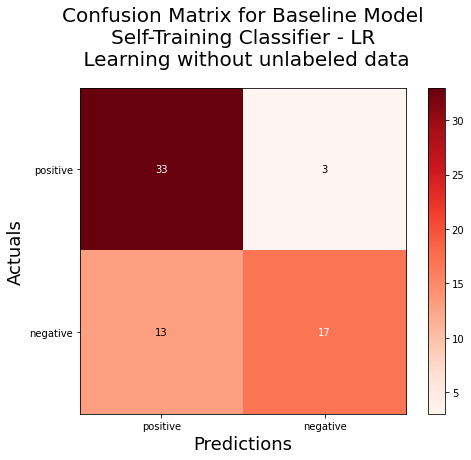

In [ ]:
model = LogisticRegression()
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X_labeled, y_labeled)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'Baseline Model\nSelf-Training Classifier - LR\n Learning without unlabeled data')

Baseline Model - SVC

Accuracy: 0.6212121212121212
Macro f1-score: 0.5139911634756995




<Figure size 432x288 with 0 Axes>

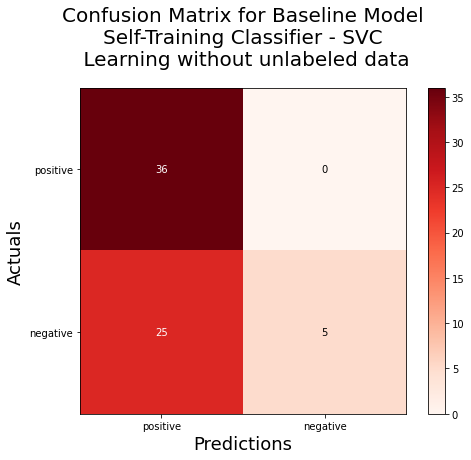

In [ ]:
model = SVC(probability=True)
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X_labeled, y_labeled)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'Baseline Model\nSelf-Training Classifier - SVC\n Learning without unlabeled data')

Logistic Regression with Self Training Classifier

Accuracy: 0.7272727272727273
Macro f1-score: 0.7144230769230769




<Figure size 432x288 with 0 Axes>

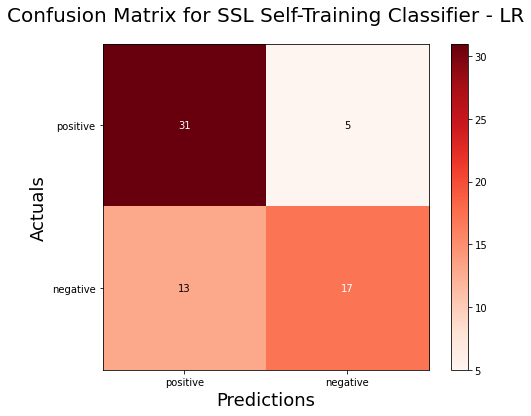

In [ ]:
model = LogisticRegression()
self_training_model = SelfTrainingClassifier(model)
self_training_model.fit(X, y)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL Self-Training Classifier - LR')

SVC with Self Training Classifier

Accuracy: 0.5454545454545454
Macro f1-score: 0.3529411764705882




<Figure size 432x288 with 0 Axes>

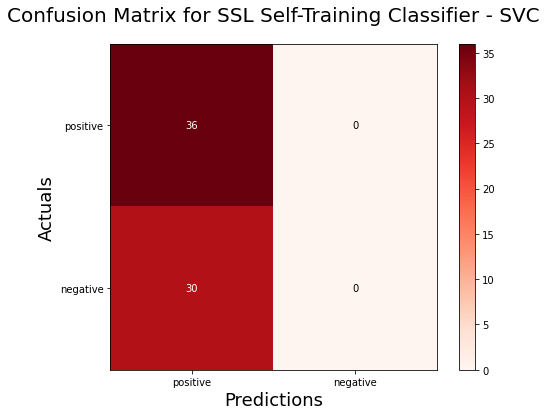

In [ ]:
svc = SVC(probability=True, gamma="auto")
self_training_model = SelfTrainingClassifier(svc)
self_training_model.fit(X, y)
y_pred = self_training_model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL Self-Training Classifier - SVC')

# Semi-Supervised GMM

Baseline model for GMM

Accuracy: 0.5454545454545454
Macro f1-score: 0.3529411764705882




<Figure size 432x288 with 0 Axes>

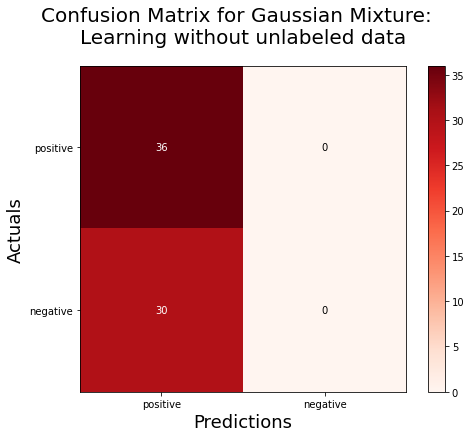

In [ ]:
X_train, X_unlab = df_train10[df_train10['Class'] != -1].iloc[:, :-1], df_train10[df_train10['Class'] == -1].iloc[:, :-1]
y_train, y_unlab = y[y.iloc[:] != -1], y[y.iloc[:] == -1]

clf = GaussianMixture(n_components=2, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
calc_metrics(y_test,y_pred,'Gaussian Mixture:  \nLearning without unlabeled data')

Mixture Models and Expectation Maximization Models - Approach 1

Accuracy: 0.5757575757575758
Macro f1-score: 0.4225




<Figure size 432x288 with 0 Axes>

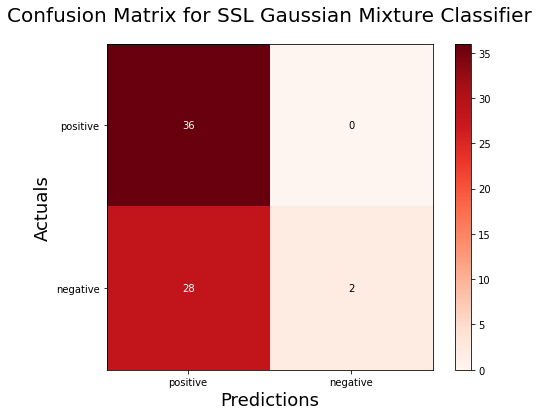

In [ ]:
#Thanks to Saptarsi Goswami for the reference
#Link https://www.kaggle.com/code/saptarsi/a-simple-semi-supervised-strategy-based-on-svm/notebook

# Estimate confidence for unlabeled data
probab = clf.predict_proba(X_unlab)
labels = clf.predict(X_unlab)

df = pd.DataFrame(probab, columns = ['Prob_Class_0', 'Prob_Class_1']) 
df['pred_label'] = labels
df['max_probab'] = df[['Prob_Class_0', 'Prob_Class_1']].max(axis=1)

# If confidence above certain threshold, append those values 
# to X_train and y_train, then retrain model
conf_levels = np.arange(.55, 1, .03)
scores = []
i = 0
max_score = float('-inf')
model = None
for k in conf_levels:
  conf_ind = df["max_probab"] > k
  X_train1 = np.append(np.array(X_train), np.array(X_unlab)[conf_ind,:], axis=0)
  y_train1 = np.append(y_train, df.loc[conf_ind, ['pred_label']])
  clf = GaussianMixture(n_components=2, random_state=0).fit(X_train1, y_train1)
  scores.append(clf.score(X_test, y_test))
  if scores[-1] >= max_score:
    max_score = scores[i]
    model = clf
  i = i + 1

y_pred = model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL Gaussian Mixture Classifier')

Mixture Models and Expectation Maximization Models - Approach 2

validation score =  0.7271753246753248
Accuracy: 0.6896551724137931
Macro f1-score: 0.6704545454545454




<Figure size 432x288 with 0 Axes>

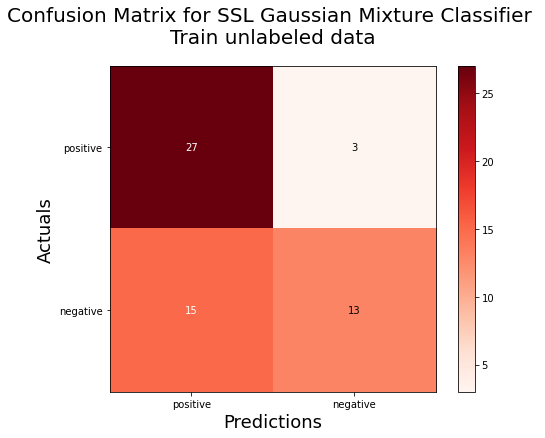




validation score =  0.8027539665862035
Accuracy: 0.7424242424242424
Macro f1-score: 0.7134099616858238




<Figure size 432x288 with 0 Axes>

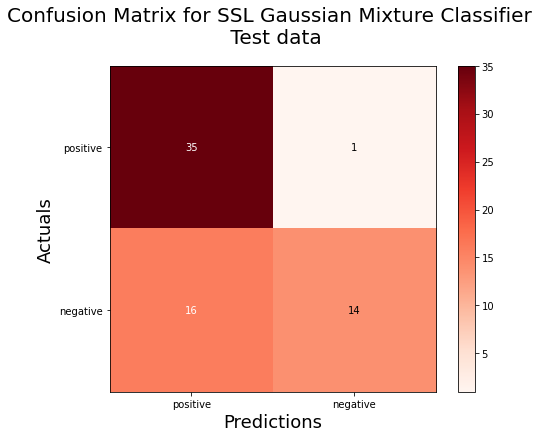

In [ ]:
bc = BaseClassifier()
bc.fit(X_train, y_train, X_unlab)
calc_metrics(y_train,bc.y_pred,'SSL Gaussian Mixture Classifier \nTrain unlabeled data')

y_train1 = pd.DataFrame(np.append(np.array(y_train), np.array(bc.y_pred_test), axis=0))
bc = BaseClassifier()
bc.fit(X, y_train1[0], X_test)
calc_metrics(y_test,bc.y_pred_test,'SSL Gaussian Mixture Classifier \n Test data')

# Semi-Supervised SVM

Baseline Model

Accuracy: 0.6212121212121212
Macro f1-score: 0.5139911634756995




<Figure size 432x288 with 0 Axes>

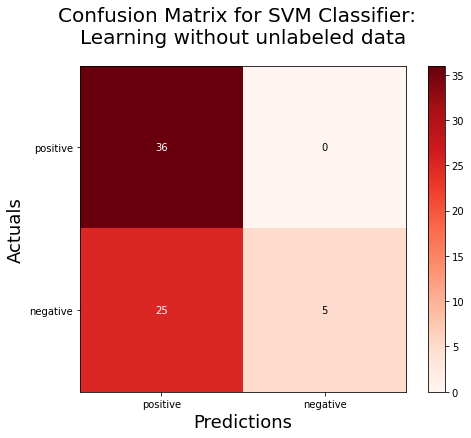

In [ ]:
X_train, X_unlab = df_train10[df_train10['Class'] != -1].iloc[:, :-1], df_train10[df_train10['Class'] == -1].iloc[:, :-1]
y_train, y_unlab = y[y.iloc[:] != -1], y[y.iloc[:] == -1]

# Use only labeled data to train a classifier
clf = SVC(kernel='rbf', probability=True,C=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
calc_metrics(y_test,y_pred,'SVM Classifier:  \nLearning without unlabeled data')

Semi-Supervised SVM - Approach 1

Accuracy: 0.6515151515151515
Macro f1-score: 0.6033446563888163




<Figure size 432x288 with 0 Axes>

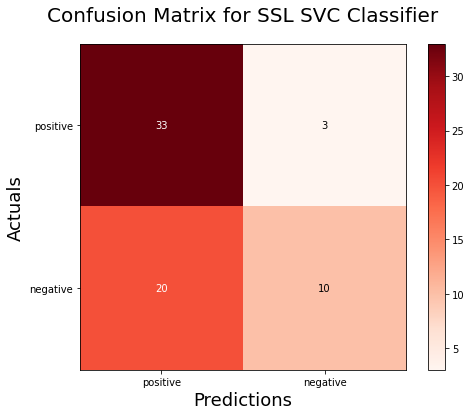

In [ ]:
#Thanks to Saptarsi Goswami for the reference
#Link https://www.kaggle.com/code/saptarsi/a-simple-semi-supervised-strategy-based-on-svm/notebook
# Estimate confidence for unlabeled data
probab = clf.predict_proba(X_unlab)
labels = clf.predict(X_unlab)

df = pd.DataFrame(probab, columns = ['Prob_Class_0', 'Prob_Class_1']) 
df['pred_label'] = labels
df['max_probab'] = df[['Prob_Class_0', 'Prob_Class_1']].max(axis=1)

# If confidence above certain threshold, append those values 
# to X_train and y_train, then retrain model
conf_levels = np.arange(.55, 1, .03)
scores = []
i = 0
max_score = 0
model = None
for k in conf_levels:
  conf_ind = df["max_probab"] > k
  X_train1 = np.append(np.array(X_train), np.array(X_unlab)[conf_ind,:], axis=0)
  y_train1 = np.append(y_train, df.loc[conf_ind, ['pred_label']])
  clf = SVC(kernel='rbf', probability=True, C=1).fit(X_train1, y_train1)
  scores.append(clf.score(X_test, y_test))
  if scores[-1] >= max_score:
    max_score = scores[i]
    model = clf
  i = i + 1

y_pred = model.predict(X_test)
calc_metrics(y_test,y_pred,'SSL SVC Classifier')

Semi-Supervised SVM - Approach 2

Accuracy: 0.6363636363636364
Macro f1-score: 0.5809523809523809




<Figure size 432x288 with 0 Axes>

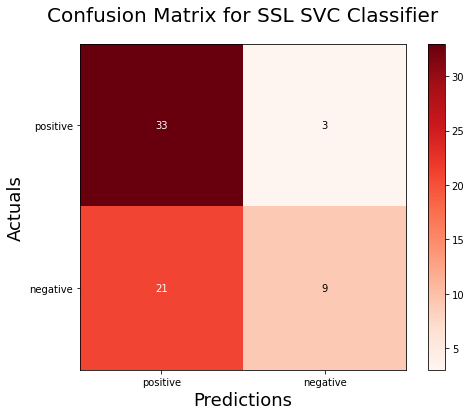

In [ ]:
X_train = X_train.astype(float)
X_unlab = X_unlab.astype(float)
X_test = X_test.astype(float)

y_train.replace(0,-1, inplace=True), y_test.replace(0,-1, inplace=True)
#Thanks to Professor Jenkins and Fabian Gieseke, Antti Airola, Tapio Pahikkala, Oliver Kramer for this piece of QN_S3VM. 
#Link https://github.com/tmadl/semisup-learn/blob/master/methods/qns3vm.py
X_list, y_list = list(X_train.values), list(y_train.values)
X_unlab = list(X_unlab.values)
s3vm = QN_S3VM(X_list, y_list, X_unlab, random.Random())
s3vm.train()
y_pred = s3vm.getPredictions(X_test)
calc_metrics(y_test,y_pred,'SSL SVC Classifier')